In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [5]:
from Bio import AlignIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [7]:
#pip install tensorflow


In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

In [11]:
alignment = AlignIO.read("alignedall.fa", "fasta")

data = {record.id: list(record.seq) for record in alignment}

df = pd.DataFrame(data).T # Transpose so rows = sequences

#df.to_csv("combined_proteins1.csv")

In [13]:
alignment = AlignIO.read("alignedall.fa", "fasta")

print("Loaded alignment:")
print("  Number of records:", len(alignment))

Loaded alignment:
  Number of records: 3319


In [16]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,572,573,574,575,576,577,578,579,580,581
QHB49174,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
QHB49175,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AQW44130,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AQW44022,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AQW44149,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [18]:
df.tail()


,0,1,2,3,4,5,6,7,8,9,...,572,573,574,575,576,577,578,579,580,581
AEF33531,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEF33506,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEF33507,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEF33544,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEN80038,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [20]:
df.shape

(3319, 582)

In [22]:
df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
577    0
578    0
579    0
580    0
581    0
Length: 582, dtype: int64

In [24]:
df.index

Index(['QHB49174', 'QHB49175', 'AQW44130', 'AQW44022', 'AQW44149', 'AQW44056',
       'AQW44165', 'AQW44139', 'AQW44132', 'AQW44131',
       ...
       'AEF33552', 'AEN75148', 'AEF33525', 'AEF33564', 'AEF33540', 'AEF33531',
       'AEF33506', 'AEF33507', 'AEF33544', 'AEN80038'],
      dtype='object', length=3319)

In [26]:
df

,0,1,2,3,4,5,6,7,8,9,...,572,573,574,575,576,577,578,579,580,581
QHB49174,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
QHB49175,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AQW44130,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AQW44022,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AQW44149,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AEF33531,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEF33506,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEF33507,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEF33544,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [28]:
# Checking full and partial sequences

full_ids = []
partial_ids = []

for record in alignment:
    seq = str(record.seq)

    if (seq[1] == '-') or (seq[-1] == '-'):
        partial_ids.append(record.id)
    else:
        full_ids.append(record.id)

print("\nSequence type counts:")
print("  Full-length sequences    :", len(full_ids))
print("  Partial / truncated seqs :", len(partial_ids))


Sequence type counts:
  Full-length sequences    : 2309
  Partial / truncated seqs : 1010


In [30]:
# making dataset with full sequence only
data_full = {record.id: list(record.seq)
             for record in alignment if record.id in full_ids}

df = pd.DataFrame(data_full).T

print("\nDF_full shape:", df.shape)
print(df.head())


DF_full shape: (2309, 582)
         0   1   2   3   4   5   6   7   8   9    ... 572 573 574 575 576 577  \
AHW83226   -   M   K   T   V   I   A   L   S   Y  ...   K   G   N   I   R   C   
AHA98464   -   M   K   T   I   I   A   L   S   Y  ...   K   G   N   I   R   C   
AHA98531   -   M   K   T   I   I   A   L   S   Y  ...   K   G   N   I   R   C   
AHA98520   -   M   K   T   I   I   A   L   S   Y  ...   K   G   N   I   R   C   
AHA98475   -   M   K   T   I   I   A   L   S   Y  ...   K   G   N   I   R   C   

         578 579 580 581  
AHW83226   N   I   C   I  
AHA98464   N   I   C   I  
AHA98531   N   I   C   I  
AHA98520   N   I   C   I  
AHA98475   N   I   C   I  

[5 rows x 582 columns]


In [32]:
df

,0,1,2,3,4,5,6,7,8,9,...,572,573,574,575,576,577,578,579,580,581
AHW83226,-,M,K,T,V,I,A,L,S,Y,...,K,G,N,I,R,C,N,I,C,I
AHA98464,-,M,K,T,I,I,A,L,S,Y,...,K,G,N,I,R,C,N,I,C,I
AHA98531,-,M,K,T,I,I,A,L,S,Y,...,K,G,N,I,R,C,N,I,C,I
AHA98520,-,M,K,T,I,I,A,L,S,Y,...,K,G,N,I,R,C,N,I,C,I
AHA98475,-,M,K,T,I,I,A,L,S,Y,...,K,G,N,I,R,C,N,I,C,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGB13250,-,M,K,A,I,L,-,-,-,-,...,N,G,S,L,Q,C,R,I,C,I
AGB13130,-,M,K,A,I,L,-,-,-,-,...,N,G,S,L,Q,C,R,I,C,I
AGB13610,-,M,K,A,I,L,-,-,-,-,...,N,G,S,L,Q,C,R,I,C,I
AEJ83837,-,M,K,A,I,L,-,-,-,-,...,N,G,S,L,Q,C,R,I,C,I


In [34]:
df.index

Index(['AHW83226', 'AHA98464', 'AHA98531', 'AHA98520', 'AHA98475', 'AHA98509',
       'ALX28912', 'ALT66905', 'AKI82580', 'QED12845',
       ...
       'AGV74461', 'AGV75616', 'AGV75319', 'AGB13240', 'AEQ33527', 'AGB13250',
       'AGB13130', 'AGB13610', 'AEJ83837', 'AEJ83840'],
      dtype='object', length=2309)

In [36]:
#encoding = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
#onehot_encoded = encoding.fit_transform(df)

In [38]:
#onehot_encoded

In [40]:
#onehot_encoded.to_csv("onehot1.csv")

In [43]:
# One-hot Encoder
df = df.astype(str)


AA20 = list("ACDEFGHIKLMNPQRSTVWY")
CATS = AA20 + ["-"]          

n_pos = df.shape[1]

enc = OneHotEncoder(
    categories=[CATS]*n_pos,
    handle_unknown="ignore",
    sparse_output=False
).set_output(transform="pandas")

ohe = enc.fit_transform(df)


cols = [f"pos{j:03d}_{aa}" for j in range(n_pos) for aa in CATS]
ohe.columns = cols
#584 sequences
print(ohe.shape)


(2309, 12222)


In [45]:
ohe.head()

,pos000_A,pos000_C,pos000_D,pos000_E,pos000_F,pos000_G,pos000_H,pos000_I,pos000_K,pos000_L,...,pos581_N,pos581_P,pos581_Q,pos581_R,pos581_S,pos581_T,pos581_V,pos581_W,pos581_Y,pos581_-
AHW83226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHA98464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHA98531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHA98520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHA98475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
ohe

,pos000_A,pos000_C,pos000_D,pos000_E,pos000_F,pos000_G,pos000_H,pos000_I,pos000_K,pos000_L,...,pos581_N,pos581_P,pos581_Q,pos581_R,pos581_S,pos581_T,pos581_V,pos581_W,pos581_Y,pos581_-
AHW83226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHA98464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHA98531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHA98520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHA98475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGB13250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGB13130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGB13610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEJ83837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
ohe.shape

(2309, 12222)

In [54]:
# reading header
original_dataset = "FASTAall.fa"
headers = []
with open(original_dataset) as f:
    for line in f:
        if line.startswith(">"):
            headers.append(line.strip())

In [56]:
headers[:5]

['>QHB49174 Influenza A virus 2017/01/23 HA',
 '>QHB49175 Influenza A virus 2017/01/24 HA',
 '>QHB49176 Influenza A virus 2017/01/24 HA',
 '>QHB49177 Influenza A virus 2017/03/01 HA',
 '>AHM98504 A/Aarhus/INS3_653/2011 2011/01/25 HA']

In [58]:
years = []
#head_name = []
for h in headers:
    y = h.split()[-2]
    year = int(y.split('/')[0])
    years.append(year)
    #head_name.append(y)
    

In [60]:
#head_name #testing
#years

In [62]:
ids = [h.split()[0].replace(">", "") for h in headers]

df_id_y = pd.DataFrame({
    "Id": ids,
    "Year": years
})

print(df_id_y.head())
print("Total IDs:", len(df_id_y))


         Id  Year
0  QHB49174  2017
1  QHB49175  2017
2  QHB49176  2017
3  QHB49177  2017
4  AHM98504  2011
Total IDs: 3319


In [64]:
year_map = df_id_y.set_index("Id")["Year"]
print("Year map length:", len(year_map))

Year map length: 3319


In [66]:
print("ohe shape:", ohe.shape)
print("Example index:", ohe.index[:5])

# Add Year column using the Id → Year map
ohe_yr = ohe.copy()
ohe_yr["Year"] = ohe_yr.index.to_series().map(year_map)

print("ohe_yr shape:", ohe_yr.shape)
print("Missing years:", ohe_yr["Year"].isna().sum())
print(ohe_yr[["Year"]].head())


ohe shape: (2309, 12222)
Example index: Index(['AHW83226', 'AHA98464', 'AHA98531', 'AHA98520', 'AHA98475'], dtype='object')
ohe_yr shape: (2309, 12223)
Missing years: 0
          Year
AHW83226  2014
AHA98464  2013
AHA98531  2013
AHA98520  2013
AHA98475  2013


In [68]:
len_full_ids = len(full_ids)
print("Number of full_ids:", len_full_ids)

mask_full = ohe_yr.index.isin(full_ids)
ohe_full = ohe_yr[mask_full].copy()

print("ohe_full shape:", ohe_full.shape)
print(ohe_full[["Year"]].head())


Number of full_ids: 2309
ohe_full shape: (2309, 12223)
          Year
AHW83226  2014
AHA98464  2013
AHA98531  2013
AHA98520  2013
AHA98475  2013


In [70]:
ohe_full

,pos000_A,pos000_C,pos000_D,pos000_E,pos000_F,pos000_G,pos000_H,pos000_I,pos000_K,pos000_L,...,pos581_P,pos581_Q,pos581_R,pos581_S,pos581_T,pos581_V,pos581_W,pos581_Y,pos581_-,Year
AHW83226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
AHA98464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
AHA98531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
AHA98520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
AHA98475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGB13250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
AGB13130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
AGB13610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
AEJ83837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011


In [73]:
ohe_yr = ohe_full.copy()

In [75]:
ohe_yr

,pos000_A,pos000_C,pos000_D,pos000_E,pos000_F,pos000_G,pos000_H,pos000_I,pos000_K,pos000_L,...,pos581_P,pos581_Q,pos581_R,pos581_S,pos581_T,pos581_V,pos581_W,pos581_Y,pos581_-,Year
AHW83226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
AHA98464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
AHA98531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
AHA98520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
AHA98475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGB13250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
AGB13130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
AGB13610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
AEJ83837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011


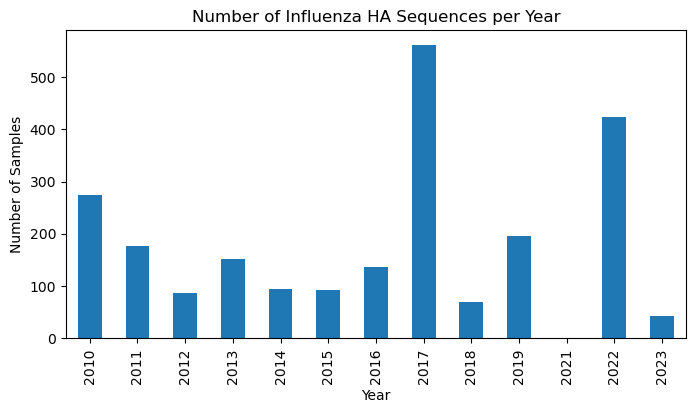

In [78]:
plt.figure(figsize=(8,4))
ohe_yr["Year"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Number of Samples")
plt.title("Number of Influenza HA Sequences per Year")
plt.show()


In [81]:
X_flat = ohe_yr.drop(columns=["Year"]).values.astype("float32")
years  = ohe_yr["Year"].to_numpy() 
num_seq, features = X_flat.shape

In [83]:
unique_positions = sorted({col.split('_')[0] for col in ohe_yr.drop(columns=["Year"]).columns})
seq_length = len(unique_positions)   
num_amino_acids = features // seq_length  

In [85]:
X = X_flat.reshape(num_seq, seq_length, num_amino_acids)

In [87]:
N, L, C = X.shape
S = X.sum(axis=2)
X_fixed = np.zeros((N, L, C + 1), dtype=X.dtype)
X_fixed[:, :, :C] = X


In [89]:
unk_mask = (S == 0.0)        
X_fixed[unk_mask, C] = 1.0 

X = X_fixed
UNK_IDX = C             
print("X with UNK:", X.shape)
print("One-hot OK:", np.allclose(X.sum(axis=2), 1.0))
print("UNK positions:", int(unk_mask.sum()))

X with UNK: (2309, 582, 22)
One-hot OK: True
UNK positions: 189


In [91]:

X_in  = X[:, :-1, :]  
y_out = X[:,  1:, :] 


train_mask = years <= 2018
test_mask  = years >  2018

X_train_full = X_in[train_mask]
y_train_full = y_out[train_mask]

X_test = X_in[test_mask]
y_test = y_out[test_mask]

print("Train sequences:", X_train_full.shape[0])
print("Test sequences :", X_test.shape[0])

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.1, random_state=42, shuffle=True
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train sequences: 1647
Test sequences : 662
Train: (1482, 581, 22) Val: (165, 581, 22) Test: (662, 581, 22)


In [93]:
def make_weights(y):
    return (y[..., UNK_IDX] == 0).astype("float32")

w_train = make_weights(y_train)
w_val   = make_weights(y_val)
w_test  = make_weights(y_test)

print("w_train:", w_train.shape)
print("UNK in train:", int((w_train == 0).sum()))

w_train: (1482, 581)
UNK in train: 143


In [95]:

L_seq = X_train.shape[1]   
C_ch  = X_train.shape[2]

model = Sequential([
    Input(shape=(L_seq, C_ch)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(C_ch, activation='softmax'))
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=7,                          
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val, w_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 59s 802ms/step - accuracy: 0.0943 - loss: 2.9569 - val_accuracy: 0.1104 - val_loss: 2.8825
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 702ms/step - accuracy: 0.1399 - loss: 2.8032 - val_accuracy: 0.1898 - val_loss: 2.6835
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 697ms/step - accuracy: 0.1969 - loss: 2.6043 - val_accuracy: 0.2198 - val_loss: 2.4780
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 705ms/step - accuracy: 0.2295 - loss: 2.4554 - val_accuracy: 0.2622 - val_loss: 2.3425
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 682ms/step - accuracy: 0.2758 - loss: 2.2549 - val_accuracy: 0.3467 - val_loss: 2.0596
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 686ms/step - accuracy: 0.2997 - loss: 2.1656 - val_accuracy: 0.1662 - val_loss: 2.6847
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 684ms/step - accuracy: 0.2204 - loss: 2.5187 - val_accuracy: 0.2925 - val_loss: 2.2577
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 685ms/step - accuracy: 0.3074 - loss: 2.1528 - 

In [122]:
model.save("lstm_model.keras") # saving model


In [97]:
model = load_model("lstm_model.keras") # loading model

In [99]:
test_loss, test_acc = model.evaluate(
    X_test, y_test,
    sample_weight=w_test,
    verbose=0
)
perplexity = np.exp(test_loss)

print(f"Test accuracy : {test_acc:.4f}")
print(f"Test loss     : {test_loss:.4f}")
print(f"Test perplexity: {perplexity:.2f}")

Test accuracy : 0.8879
Test loss     : 0.5436
Test perplexity: 1.72


In [102]:
y_pred = model.predict(X_test, verbose=0)


In [104]:
amino_acid = ['A','C','D','E','F','G','H','I','K','L',
              'M','N','P','Q','R','S','T','V','W','Y','-','UNK']

true_idx = np.argmax(y_test, axis=-1)   
pred_idx = np.argmax(y_pred, axis=-1)

def decode_idx(row):
    return "".join(amino_acid[i] for i in row)

for i in range(3):
    print(f"--- Test {i+1} ---")
    print("TRUE:", decode_idx(true_idx[i]))
    print("\nPRED:", decode_idx(pred_idx[i]))
    print()



--- Test 1 ---
TRUE: MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICD-SPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFV--ERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFN---W-TGVKQNGTSSACIRKSSSSFFSRLNWLTHL--NYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITISTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIQSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYK-DWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI

PRED: -NTIAALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICD-SPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFV--ERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNEESFN---W-TGVTTNGTSSACIRRSSSFFFSRLNWLTHL--NYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEG

In [106]:
test = 661
print("TRUE:\n", decode_idx(true_idx[test]))
print("\nPRED:\n",decode_idx(pred_idx[test]))

TRUE:
 MKTIIALSNILCLVFAQKIPGNDNSMATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICG-SPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFV--ERSRANSNCYPYDVPGYASLRSLVASSGTLEFKNESFN---W-TGVKQNGTSSACKRGSSSSFFSRLNWLTSL--NNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGK-SSIMRSDAPIGRCKSECITPNGSIPNDKPFQNVNKITYGACPRYVKQSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRVQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTRKQLRENAEDMGNGCFKIYHKCDNACIGSIRNETYDHNVYRDEALNNRFQIKGVELKSGYK-DWILWISFAMSCFLLCIALLGFIMWACQKGNIRCNICI

PRED:
 -NTIAALSYYLYYYFAQKIPGNDNSTTTLCLIHHAPPGGTIVKTINNDRIETTNATELVQNSSIGEICDDDPHQILDGENCTIIDALLGDPQCDGFQNKKKLLFV---SSKSYAYYYPYDVPYYASLRSLVASSGTLESNNSSNN-----TGVQTNGTSSACIIINNSFFFLLLNWLTHH-NNYYYTALLLTPPNKYFFDKLYIWGVHHPGGKKVVILLYAQIIIYITVSTKVSVVVVILGGGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGK-SSIMRSDAPIGKKKSECITPNGSIPNDKPFQNVNRTTYGACPRYVKHSTLKLATGMRNVPEK-----TRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAA

In [108]:
years_train = years[train_mask]
years_test  = years[test_mask]

print("Unique years in test:", np.unique(years_test))


Unique years in test: [2019 2021 2022 2023]


In [110]:
yr = 2019
indices_yr = np.where(years_test == yr)[0]
print("Number of test sequences from 2023:", len(indices_yr))


chosen = indices_yr[:2] # first 2 data

for idx in chosen:
    print(f"--- {yr} Sample {idx} ---")
    print("Year:", years_test[idx])
    print("TRUE:", decode_idx(true_idx[idx]))
    print("\nPRED:", decode_idx(pred_idx[idx]))
    print()


Number of test sequences from 2023: 195
--- 2019 Sample 0 ---
Year: 2019
TRUE: MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICD-SPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFV--ERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFN---W-TGVKQNGTSSACIRKSSSSFFSRLNWLTHL--NYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITISTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIQSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYK-DWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI

PRED: -NTIAALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICD-SPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFV--ERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNEESFN---W-TGVTTNGTSSACIRRSSSFFFSRLNWLTHL--NYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACP

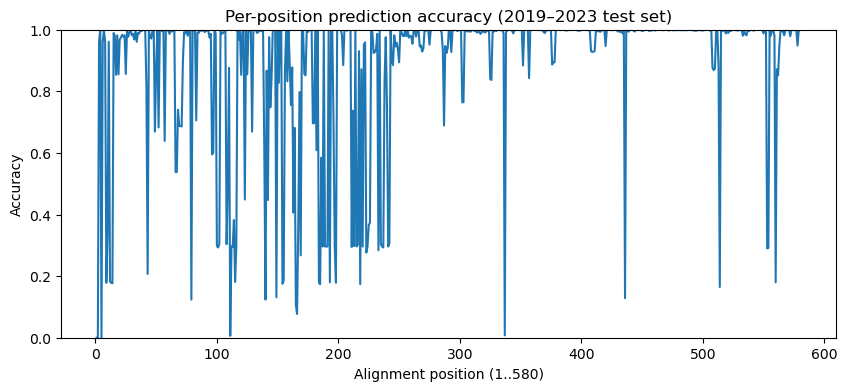

In [112]:
UNK_IDX = amino_acid.index('UNK')
mask = (true_idx != UNK_IDX)

correct = (true_idx == pred_idx) & mask
pos_acc = correct.sum(axis=0) / mask.sum(axis=0)   # (580,)

seq_length = pos_acc.shape[0]


plt.figure(figsize=(10,4))
plt.plot(range(1, seq_length+1), pos_acc)
plt.xlabel("Alignment position (1..580)")
plt.ylabel("Accuracy")
plt.title("Per-position prediction accuracy (2019–2023 test set)")
plt.ylim(0, 1)
plt.show()


In [114]:
L = pos_acc.shape[0]

positions = np.arange(1, L+1)

# sort indices by accuracy
sorted_idx = np.argsort(pos_acc)   # ascending


worst_k = 10
worst_positions = positions[sorted_idx[:worst_k]]
worst_accs = pos_acc[sorted_idx[:worst_k]]

print("Worst positions:")
for p, a in zip(worst_positions, worst_accs):
    print(f"  pos {p:3d}: accuracy={a:.3f}")


best_k = 10
best_positions = positions[sorted_idx[-best_k:]][::-1]
best_accs = pos_acc[sorted_idx[-best_k:]][::-1]

print("\nBest positions:")
for p, a in zip(best_positions, best_accs):
    print(f"  pos {p:3d}: accuracy={a:.3f}")


Worst positions:
  pos   1: accuracy=0.000
  pos   2: accuracy=0.000
  pos   5: accuracy=0.000
  pos 111: accuracy=0.006
  pos 337: accuracy=0.008
  pos 166: accuracy=0.077
  pos 165: accuracy=0.107
  pos 140: accuracy=0.124
  pos  79: accuracy=0.124
  pos 436: accuracy=0.128

Best positions:
  pos 581: accuracy=1.000
  pos 331: accuracy=1.000
  pos 389: accuracy=1.000
  pos 385: accuracy=1.000
  pos 384: accuracy=1.000
  pos 382: accuracy=1.000
  pos 381: accuracy=1.000
  pos 380: accuracy=1.000
  pos 379: accuracy=1.000
  pos 375: accuracy=1.000


In [116]:
true_flat = true_idx.flatten()
pred_flat = pred_idx.flatten()


mask = true_flat != UNK_IDX
true_flat = true_flat[mask]
pred_flat = pred_flat[mask]

labels_no_unk = amino_acid[:-1]

print(classification_report(true_flat, pred_flat,
                            target_names=labels_no_unk))




              precision    recall  f1-score   support

           A       0.93      0.93      0.93     20558
           C       0.96      0.87      0.91     11993
           D       0.92      0.91      0.91     19418
           E       0.92      0.86      0.89     18755
           F       0.89      0.93      0.91     14316
           G       0.91      0.92      0.92     28330
           H       0.87      1.00      0.93      7084
           I       0.87      0.90      0.89     33801
           K       0.90      0.85      0.88     24563
           L       0.89      0.95      0.92     28049
           M       0.97      0.68      0.80      5890
           N       0.88      0.86      0.87     29414
           P       0.94      0.94      0.94     13244
           Q       0.98      0.74      0.85     16481
           R       0.97      0.86      0.91     18474
           S       0.91      0.81      0.86     29018
           T       0.87      0.98      0.92     20540
           V       0.80    

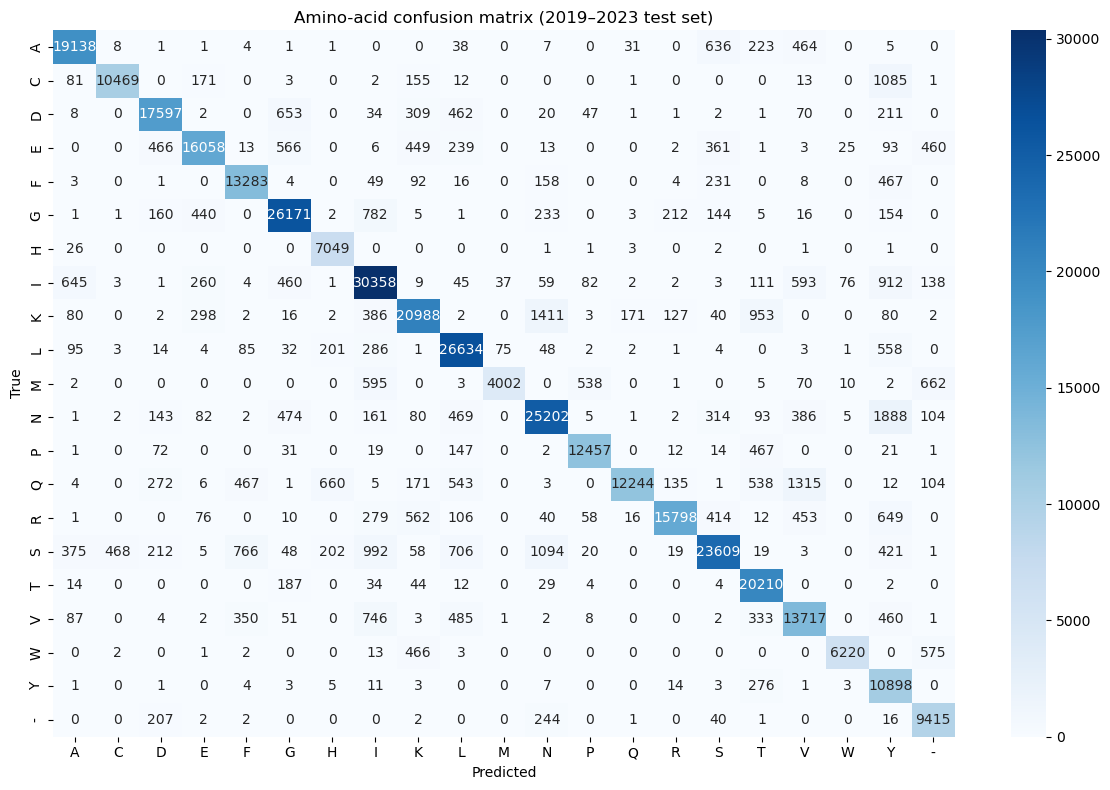

In [118]:
cm = confusion_matrix(true_flat, pred_flat, labels=range(len(labels_no_unk)))

plt.figure(figsize=(12,8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap="Blues",
            xticklabels=labels_no_unk,
            yticklabels=labels_no_unk)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Amino-acid confusion matrix (2019–2023 test set)")
plt.tight_layout()
plt.show()

In [270]:
#Gated recurrent unit

In [121]:
gru_model = Sequential([
    Input(shape=(L_seq, C_ch)),
    GRU(128, return_sequences=True),   # GRU instead of LSTM
    Dropout(0.2),
    TimeDistributed(Dense(C_ch, activation='softmax'))
])

gru_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

gru_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 581, 128)            │          58,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 581, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 581, 22)             │           2,838 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,206 (239.09 KB)

 Trainable params: 61,206 (239.09 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
early_stop_gru = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)


In [137]:
history_gru = gru_model.fit(
    X_train, y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val, w_val),
    callbacks=[early_stop_gru],
    verbose=1
)


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.0966 - loss: 2.9592 - val_accuracy: 0.1343 - val_loss: 2.8618
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 793ms/step - accuracy: 0.1546 - loss: 2.7703 - val_accuracy: 0.1935 - val_loss: 2.6325
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 794ms/step - accuracy: 0.2248 - loss: 2.5304 - val_accuracy: 0.2904 - val_loss: 2.3623
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 785ms/step - accuracy: 0.3202 - loss: 2.2517 - val_accuracy: 0.3849 - val_loss: 2.0688
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 781ms/step - accuracy: 0.4173 - loss: 1.9564 - val_accuracy: 0.4877 - val_loss: 1.7592
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 810ms/step - accuracy: 0.5104 - loss: 1.6709 - val_accuracy: 0.5949 - val_loss: 1.4554
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 796ms/step - accuracy: 0.5957 - loss: 1.3973 - val_accuracy: 0.6948 - val_loss: 1.1665
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 796ms/step - accuracy: 0.6774 - loss: 1.1360 - val

In [143]:
gru_model.save("gru_model.keras")

In [125]:
gru_model = load_model("gru_model.keras") # loading model

C:\Users\sandesh\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [127]:
gru_test_loss, gru_test_acc = gru_model.evaluate(
    X_test, y_test,
    sample_weight=w_test,
    verbose=0
)


In [129]:
gru_perplexity = np.exp(gru_test_loss)

print("GRU Test Performance")
print(f"GRU test accuracy : {gru_test_acc:.4f}")
print(f"GRU test loss     : {gru_test_loss:.4f}")
print(f"GRU test perplexity: {gru_perplexity:.2f}")

GRU Test Performance
GRU test accuracy : 0.9257
GRU test loss     : 0.4536
GRU test perplexity: 1.57


In [132]:
y_pred_gru = gru_model.predict(X_test, verbose=0)

# Indices for true and predicted amino-acids
true_idx_gru = np.argmax(y_test, axis=-1)      
pred_idx_gru = np.argmax(y_pred_gru, axis=-1)  


In [155]:
for i in range(3):
    print(f"GRU Test ---")
    print("TRUE:", decode_idx(true_idx_gru[i]))
    print("\nPRED:", decode_idx(pred_idx_gru[i]))
    print()


GRU Test ---
TRUE: MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICD-SPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFV--ERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFN---W-TGVKQNGTSSACIRKSSSSFFSRLNWLTHL--NYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITISTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIQSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYK-DWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI

PRED: MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICD-SPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFV--ERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFN---W-TGVTQNGTSSACIRKSSSSFFSRLNWLTHL--NYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRG

In [161]:
years_train = years[train_mask]
years_test  = years[test_mask]

print("Unique years in test (GRU):", np.unique(years_test))

yr = 2019
indices_yr = np.where(years_test == yr)[0]
print(f"Number of test sequences from {yr}:", len(indices_yr))

chosen = indices_yr[:2]

for idx in chosen:
    print(f"GRU {yr} Sample {idx}")
    print("Year:", years_test[idx])
    print("TRUE:", decode_idx(true_idx_gru[idx]))
    print("\nPRED:", decode_idx(pred_idx_gru[idx]))
    print()


Unique years in test (GRU): [2019 2021 2022 2023]
Number of test sequences from 2019: 195
GRU 2019 Sample 0
Year: 2019
TRUE: MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICD-SPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFV--ERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFN---W-TGVKQNGTSSACIRKSSSSFFSRLNWLTHL--NYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITISTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIQSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYK-DWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI

PRED: MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICD-SPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFV--ERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFN---W-TGVTQNGTSSACIRKSSSSFFSRLNWLTHL--NYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIR

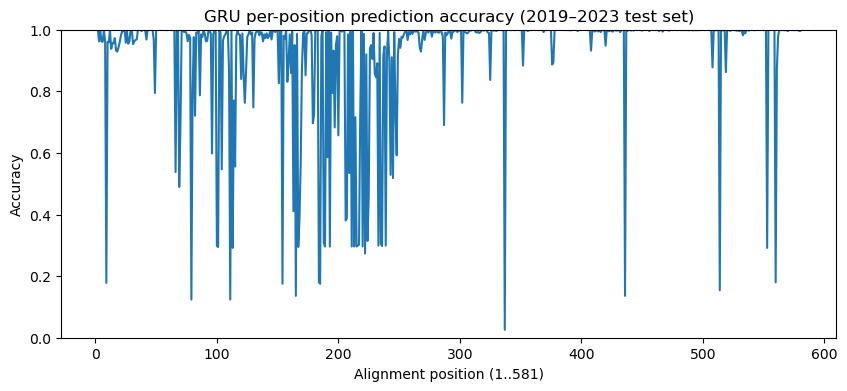

In [165]:
UNK_IDX = amino_acid.index('UNK')

mask_pos = (true_idx_gru != UNK_IDX)

correct_pos = (true_idx_gru == pred_idx_gru) & mask_pos
pos_acc_gru = correct_pos.sum(axis=0) / mask_pos.sum(axis=0)   # shape (L-1,)

seq_length = pos_acc_gru.shape[0]
positions = np.arange(1, seq_length+1)

plt.figure(figsize=(10,4))
plt.plot(positions, pos_acc_gru)
plt.xlabel("Alignment position (1..581)")
plt.ylabel("Accuracy")
plt.title("GRU per-position prediction accuracy (2019–2023 test set)")
plt.ylim(0, 1)
plt.show()


In [167]:
sorted_idx = np.argsort(pos_acc_gru)   # ascending

worst_k = 10
worst_positions_gru = positions[sorted_idx[:worst_k]]
worst_accs_gru      = pos_acc_gru[sorted_idx[:worst_k]]

print("GRU – Worst positions:")
for p, a in zip(worst_positions_gru, worst_accs_gru):
    print(f"  pos {p:3d}: accuracy={a:.3f}")

best_k = 10
best_positions_gru = positions[sorted_idx[-best_k:]][::-1]
best_accs_gru      = pos_acc_gru[sorted_idx[-best_k:]][::-1]

print("\nGRU – Best positions:")
for p, a in zip(best_positions_gru, best_accs_gru):
    print(f"  pos {p:3d}: accuracy={a:.3f}")


GRU – Worst positions:
  pos 337: accuracy=0.026
  pos 111: accuracy=0.124
  pos  79: accuracy=0.124
  pos 436: accuracy=0.136
  pos 165: accuracy=0.136
  pos 514: accuracy=0.154
  pos 185: accuracy=0.175
  pos 154: accuracy=0.175
  pos   9: accuracy=0.178
  pos 184: accuracy=0.180

GRU – Best positions:
  pos 291: accuracy=1.000
  pos 372: accuracy=1.000
  pos 393: accuracy=1.000
  pos 389: accuracy=1.000
  pos 387: accuracy=1.000
  pos 385: accuracy=1.000
  pos 384: accuracy=1.000
  pos 383: accuracy=1.000
  pos 382: accuracy=1.000
  pos 381: accuracy=1.000


In [171]:
true_flat_gru = true_idx_gru.flatten()
pred_flat_gru = pred_idx_gru.flatten()

mask_flat = (true_flat_gru != UNK_IDX)
true_flat_gru = true_flat_gru[mask_flat]
pred_flat_gru = pred_flat_gru[mask_flat]

labels_no_unk = amino_acid[:-1]

print("GRU classification report")
print(classification_report(true_flat_gru, pred_flat_gru,
                            target_names=labels_no_unk))


GRU classification report
              precision    recall  f1-score   support

           A       0.94      0.95      0.94     20558
           C       0.97      0.99      0.98     11993
           D       0.90      0.93      0.91     19418
           E       0.92      0.92      0.92     18755
           F       0.90      0.93      0.91     14316
           G       0.96      0.91      0.93     28330
           H       0.85      0.95      0.90      7084
           I       0.93      0.93      0.93     33801
           K       0.90      0.92      0.91     24563
           L       0.94      0.98      0.96     28049
           M       0.98      0.81      0.89      5890
           N       0.92      0.90      0.91     29414
           P       0.98      0.98      0.98     13244
           Q       0.98      0.80      0.88     16481
           R       0.95      0.89      0.92     18474
           S       0.94      0.91      0.93     29018
           T       0.89      0.98      0.93     20540
 

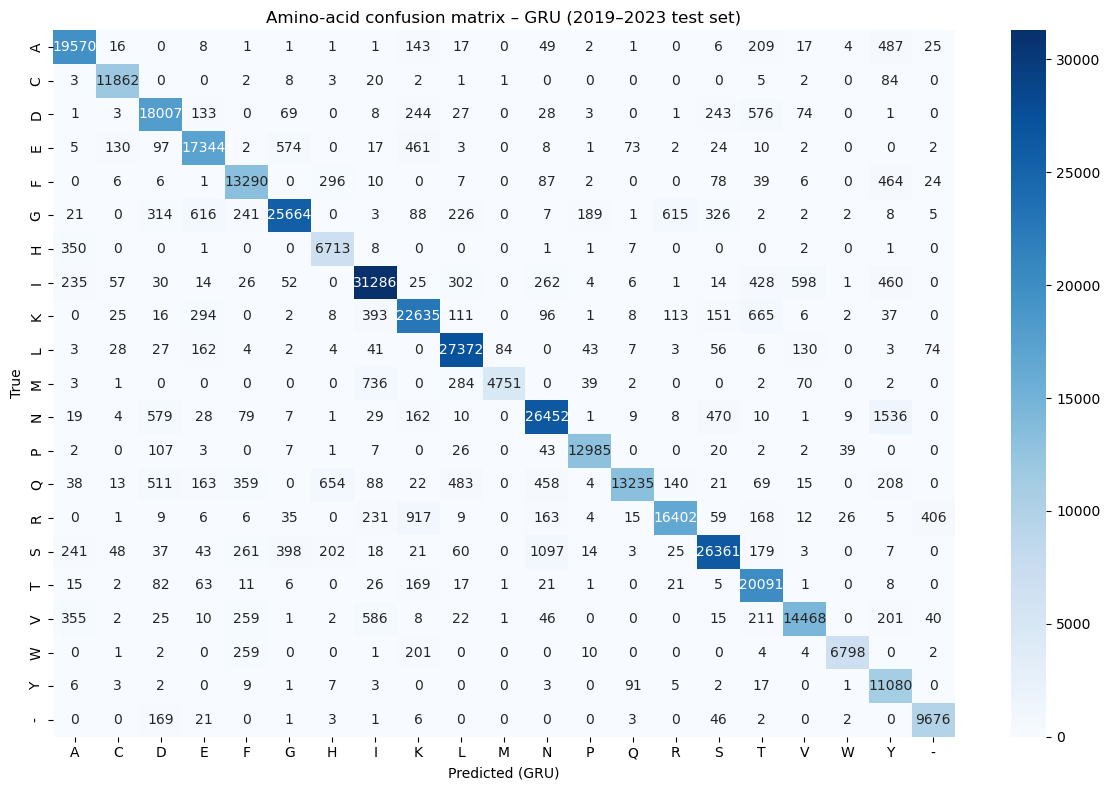

In [173]:
cm_gru = confusion_matrix(true_flat_gru, pred_flat_gru,
                          labels=range(len(labels_no_unk)))

plt.figure(figsize=(12,8))
sns.heatmap(cm_gru,
            annot=True,
            fmt='d',
            cmap="Blues",
            xticklabels=labels_no_unk,
            yticklabels=labels_no_unk)
plt.xlabel("Predicted (GRU)")
plt.ylabel("True")
plt.title("Amino-acid confusion matrix – GRU (2019–2023 test set)")
plt.tight_layout()
plt.show()


In [272]:
latest_year = years_test.max()
print("Latest real year in test set:", latest_year)

mask_latest = (years_test == latest_year)
X_seed = X_test[mask_latest]

print("Number of sequences from latest year:", X_seed.shape[0])


Latest real year in test set: 2023
Number of sequences from latest year: 43


In [277]:

y_pred_synth = gru_model.predict(X_seed, verbose=0)

# Convert probabilities → amino acid index
synth_idx = np.argmax(y_pred_synth, axis=-1)

# Decode function
def decode_row(idx_row):
    return "".join(amino_acid[i] for i in idx_row)


In [281]:
print("SYNTHETIC SEQUENCES  (GRU generated)\n")

for i in range(5):   # change to print more
    print(f"Synthetic Sequence {i+1}")
    print(decode_row(synth_idx[i]))
    print()


SYNTHETIC SEQUENCES (GRU generated)

Synthetic Sequence 1
MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICE-SPHQILDGESCTLIDKLLGDPQCDGFQNKKFDLHV--ERSKAYSNCYPYDVDDQASLRSLVASSGTLEFKNESFN---W-TGVTQNGTSSACIRRSNNSFFSRLNWLTHL--NYYYPYLNVTLPNKEQFDKLYIWPTHAPTTTKDDTSLYANSGRRITVSTK-SYFAVAPNISSIPNNRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYK-DWILWISFAISCFLLCNALLGFIMWACQKGNIRCNICI

Synthetic Sequence 2
MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICE-SPHQILDGESCTLIDKLLGDPQCDGFQNKKFDLHV--ERSKAYSNCYPYDVDDQASLRSLVASSGTLEFKNESFN---W-TGVTQNGTSSACIRRSNNSFFSRLNWLTHL--NYYYPYLNVTLPNKEQFDKLYIWPTHAPTTTKDDTSLYANSGRRITVSTK-SYFAVAPNGSSIPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGK-SSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHS

In [134]:
df_chars_full = df.astype(str).copy()
df_chars_full["Year"] = df_chars_full.index.to_series().map(year_map).astype(int)

align_cols = df_chars_full.columns[:-1]  
L = len(align_cols)                   

years_sorted = sorted(df_chars_full["Year"].unique())
print("Years:", years_sorted, "L =", L)


Years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023] L = 582


In [136]:

mut_matrix = np.zeros((len(years_sorted), L), dtype=float)

for i, yr in enumerate(years_sorted):
    sub = df_chars_full[df_chars_full["Year"] == yr][align_cols].to_numpy(dtype=str)  # n_seq_year × 582

    if sub.shape[0] == 0:
        continue

    for j in range(L):
        col = sub[:, j]                       # all residues at position j in this year
        vals, counts = np.unique(col, return_counts=True)
        consensus_count = counts.max()
        total = counts.sum()
        mut_matrix[i, j] = 1.0 - consensus_count / total

print("mut_matrix shape:", mut_matrix.shape)   # (n_years, 582)


mut_matrix shape: (13, 582)


In [138]:
mean_mut_rate = mut_matrix.mean(axis=0)   # length 582
print(mean_mut_rate.shape)


(582,)


In [140]:
top_k = 20

# indices of top-20 positions (0-based)
top_idx = np.argsort(mean_mut_rate)[-top_k:]
top_idx_sorted = np.sort(top_idx)

# 1-based positions for labels
top_positions = top_idx_sorted + 1

print("Top-20 hotspot positions (1-based):", top_positions)


Top-20 hotspot positions (1-based): [ 50  70  80  97 124 141 142 152 155 159 164 166 168 180 185 186 197 287
 288 338]


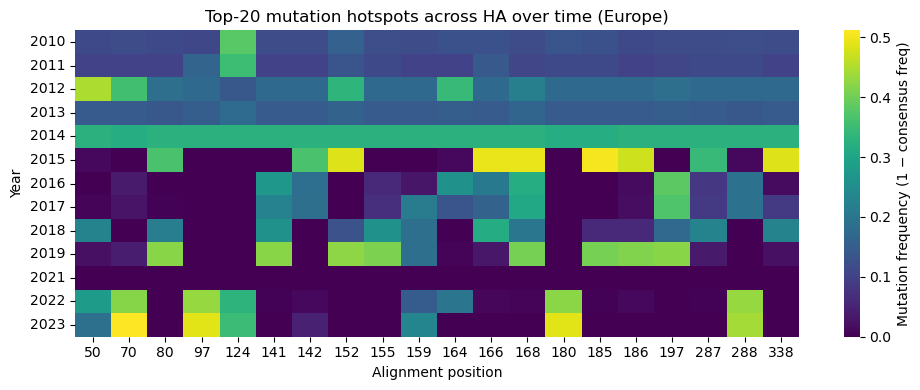

In [142]:
plt.figure(figsize=(10, 4))

sns.heatmap(
    mut_matrix[:, top_idx_sorted],
    cmap="viridis",
    xticklabels=top_positions,
    yticklabels=years_sorted,
    cbar_kws={"label": "Mutation frequency (1 − consensus freq)"}
)

plt.xlabel("Alignment position")
plt.ylabel("Year")
plt.title("Top-20 mutation hotspots across HA over time (Europe)")
plt.tight_layout()
plt.show()


In [321]:
mean_mut_rate_pred = mean_mut_rate[1:]
print(mean_mut_rate_pred.shape, pos_acc_gru.shape) 


(581,) (581,)


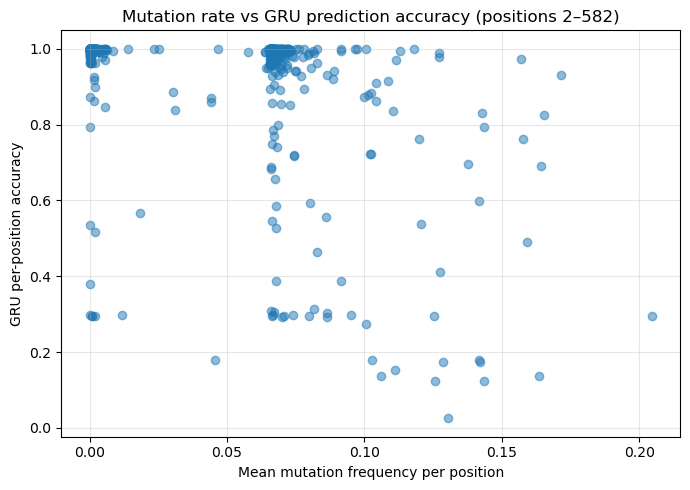

In [325]:
plt.figure(figsize=(7,5))
plt.scatter(mean_mut_rate_pred, pos_acc_gru, alpha=0.5)

plt.xlabel("Mean mutation frequency per position")
plt.ylabel("GRU per-position accuracy")
plt.title("Mutation rate vs GRU prediction accuracy (positions 2–582)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [327]:
corr = np.corrcoef(mean_mut_rate_pred, pos_acc_gru)[0,1]
print("Correlation:", corr)

Correlation: -0.3548639179159004
